In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [41]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/NOK.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [49]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [50]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-1084.547, Time=2.60 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1057.612, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1084.898, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1081.099, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1059.548, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1086.711, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-1084.897, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1082.902, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-1088.107, Time=0.17 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-1086.276, Time=0.54 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=-1086.274, Time=0.53 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-1084.281, Time=1.75 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=-1086.118, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-1086.111, Time=1.16 sec
 ARIM

In [51]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([4.91326045, 4.91110764, 4.998465  , 4.96008635, 4.90495325,
       4.76172957, 4.7562182 , 4.7286738 , 4.73969165, 4.73418269,
       4.73969167, 4.75070966, 4.73418268, 4.76723664, 4.74520067,
       4.7947816 , 4.82783555, 4.7947816 , 4.84436253, 4.90496144,
       4.87741648, 4.91047044, 4.94903338, 4.96005137, 4.88843447,
       4.87741648, 4.80029059, 4.72867369, 4.75621865, 4.7231647 ,
       4.74520067, 4.86088951, 4.82232656, 4.82783555, 4.80579958,
       4.87741648, 4.90496144, 4.86088951, 4.78376361, 4.78927261,
       4.78376361, 4.78376361, 4.76172765, 4.76723664, 4.78927261,
       4.7947816 , 4.81130858, 4.81681757, 4.80029059, 4.76723664,
       4.77825462, 4.72867369, 4.77825462, 4.75621865, 4.75621865,
       4.77274563, 4.85538051, 4.85538051, 4.85538051, 4.80579958,
       4.84436253, 4.81681757, 4.77825462, 4.78376361, 4.66807478,
       4.70663772, 4.67909276, 4.7231647 , 4.76172765, 4.78376361,
       4.77274563, 4.74520067, 4.7947816 , 4.76172765, 4.80579

In [52]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([4.91326045, 4.91110764, 4.998465  , 4.96008635, 4.90495325,
       4.76172957, 4.7562182 , 4.7286738 , 4.73969165, 4.73418269,
       4.73969167, 4.75070966, 4.73418268, 4.76723664, 4.74520067,
       4.7947816 , 4.82783555, 4.7947816 , 4.84436253, 4.90496144,
       4.87741648, 4.91047044, 4.94903338, 4.96005137, 4.88843447,
       4.87741648, 4.80029059, 4.72867369, 4.75621865, 4.7231647 ,
       4.74520067, 4.86088951, 4.82232656, 4.82783555, 4.80579958,
       4.87741648, 4.90496144, 4.86088951, 4.78376361, 4.78927261,
       4.78376361, 4.78376361, 4.76172765, 4.76723664, 4.78927261,
       4.7947816 , 4.81130858, 4.81681757, 4.80029059, 4.76723664,
       4.77825462, 4.72867369, 4.77825462, 4.75621865, 4.75621865,
       4.77274563, 4.85538051, 4.85538051, 4.85538051, 4.80579958,
       4.84436253, 4.81681757, 4.77825462, 4.78376361, 4.66807478,
       4.70663772, 4.67909276, 4.7231647 , 4.76172765, 4.78376361,
       4.77274563, 4.74520067, 4.7947816 , 4.76172765, 4.80579

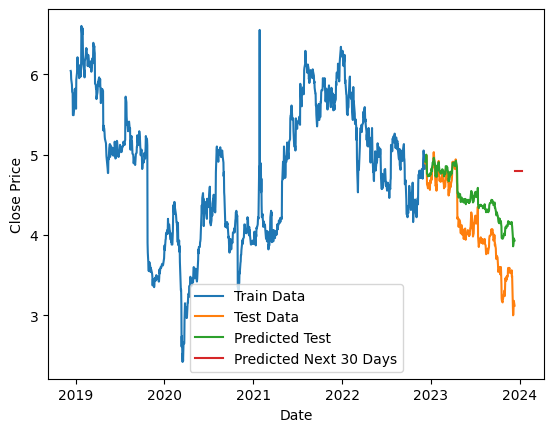

In [53]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [54]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 0.344
Testing RMSE: 0.409
Testing MAPE: 9.101


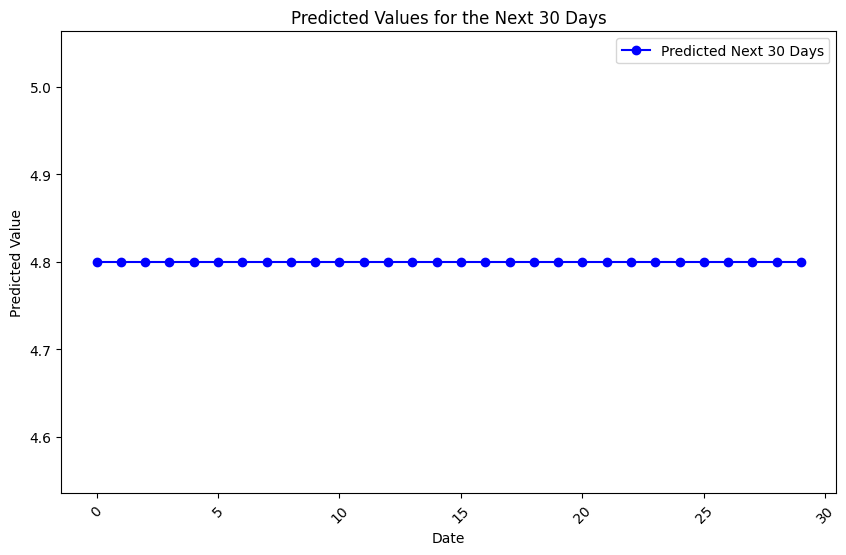

In [55]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


